# Imports

## Pakages

In [58]:
# Data Handling
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
import os, datetime, copy
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf

# Models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, metrics, losses

In [59]:
tf.__version__

'2.10.0'

In [60]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Notebook Config

In [79]:
class cfg:
    base_dir = os.getcwd()
    data_dir = f'{base_dir}\\Data\\train data 2.csv'
    is_validation_phase = True
    color = sns.color_palette()
    split_date = '2022-10-01'
    window_size = 5

## Importing Data

In [80]:
df = pd.read_csv(cfg.data_dir)
df.date = pd.to_datetime(df.date)
df = df.set_index('date')
print(df.index)
#df = df.drop(['high', 'low'], axis = 1)
df.head()

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 01:00:00',
               '2019-01-01 02:00:00', '2019-01-01 03:00:00',
               '2019-01-01 04:00:00', '2019-01-01 05:00:00',
               '2019-01-01 06:00:00', '2019-01-01 07:00:00',
               '2019-01-01 08:00:00', '2019-01-01 09:00:00',
               ...
               '2022-11-28 16:00:00', '2022-11-28 17:00:00',
               '2022-11-28 18:00:00', '2022-11-28 19:00:00',
               '2022-11-28 20:00:00', '2022-11-28 21:00:00',
               '2022-11-28 22:00:00', '2022-11-28 23:00:00',
               '2022-11-29 00:00:00', '2022-11-29 01:00:00'],
              dtype='datetime64[ns]', name='date', length=34274, freq=None)


,open,high,low,close
date,,,,
2019-01-01 00:00:00,131.361407,132.172291,131.173792,131.864147
2019-01-01 01:00:00,131.670000,131.761773,130.852452,131.185498
2019-01-01 02:00:00,131.231926,131.260690,130.082442,130.593948
2019-01-01 03:00:00,130.840632,131.432148,130.840632,131.227012
2019-01-01 04:00:00,131.352223,133.943697,131.294581,132.261349


In [81]:
df.tail()

,open,high,low,close
date,,,,
2022-11-28 21:00:00,1174.90,1175.19,1167.84,1172.61
2022-11-28 22:00:00,1172.61,1173.41,1170.37,1170.78
2022-11-28 23:00:00,1170.87,1171.93,1166.16,1167.67
2022-11-29 00:00:00,1167.68,1169.93,1158.55,1167.18
2022-11-29 01:00:00,1167.17,1168.79,1165.43,1166.17


In [82]:
df.shape

(34274, 4)

# Data Visualization

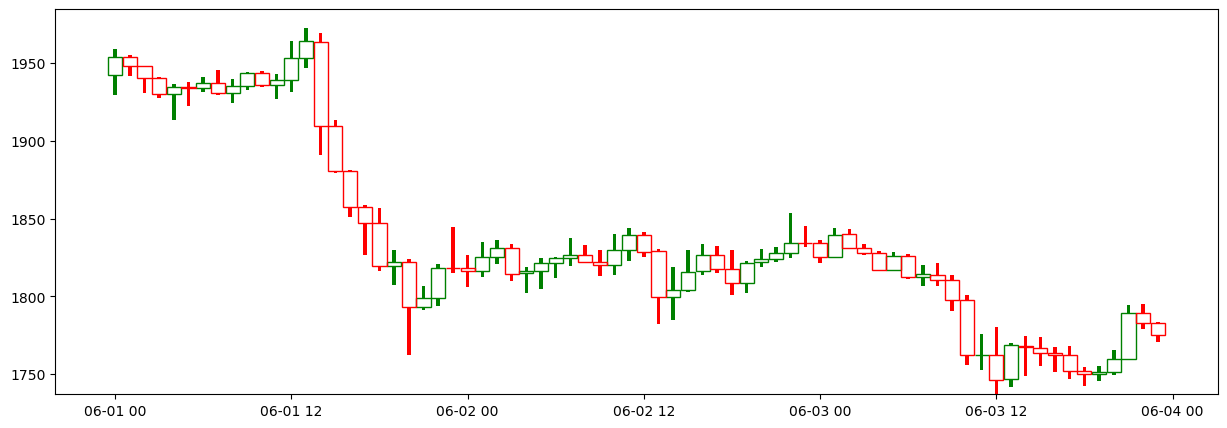

In [83]:
index_range = ('2022-06-01','2022-06-03')
inc = df[df.open<=df.close].loc[index_range[0]:index_range[1]]
dec = df[df.open> df.close].loc[index_range[0]:index_range[1]]

w1 = ((len(inc)+len(dec))*0.04)/(len(inc)+len(dec))
w2 = ((len(inc)+len(dec))*0.01)/(len(inc)+len(dec))

plt.figure(figsize=(15,5))
plt.bar(inc.index, (inc.close-inc.open), width=w1, bottom=inc.open, edgecolor='g', fill=False)
plt.bar(dec.index, (dec.close-dec.open), width=w1, bottom=dec.open, edgecolor='r', fill=False)
plt.bar(inc.index, (inc.high-inc.close), width=w2, bottom=inc.close, color='g', fill=True)
plt.bar(inc.index, (inc.open-inc.low), width=w2, bottom=inc.low, color='g', fill=True)
plt.bar(dec.index, (dec.close-dec.low), width=w2, bottom=dec.low, color='r', fill=True)
plt.bar(dec.index, (dec.high-dec.open), width=w2, bottom=dec.open, color='r', fill=True)

plt.show()

# Modeling

## Preping Data

In [84]:
new_df = df.copy().drop(['high', 'low'], axis=1)
new_df['diff'] = new_df.close.diff()
new_df['close-open'] = new_df.close-new_df.open
new_df['(close-open)/open'] = new_df['close-open']/new_df.open
new_df = new_df.dropna()
new_df['diff>0'] = (new_df['diff']>0)
new_df['close-open>0'] = (new_df['close-open']>0)
new_df['(close-open)/open>0'] = (new_df['(close-open)/open']>0)

new_df['hour'] = new_df.index.hour
new_df['day of week'] = new_df.index.day_of_week
new_df['day of month'] = new_df.index.day
new_df['day of year'] = new_df.index.day_of_year
new_df['week'] = new_df.index.week
new_df['month'] = new_df.index.month
new_df['year'] = new_df.index.year

C:\Users\Amirhossein\AppData\Local\Temp\ipykernel_23208\1122028106.py:14: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  new_df['week'] = new_df.index.week


In [85]:
new_df.head()

,open,close,diff,close-open,(close-open)/open,diff>0,close-open>0,(close-open)/open>0,hour,day of week,day of month,day of year,week,month,year
date,,,,,,,,,,,,,,,
2019-01-01 01:00:00,131.670000,131.185498,-0.678649,-0.484502,-0.003680,False,False,False,1,1,1,1,1,1,2019
2019-01-01 02:00:00,131.231926,130.593948,-0.591550,-0.637978,-0.004861,False,False,False,2,1,1,1,1,1,2019
2019-01-01 03:00:00,130.840632,131.227012,0.633064,0.386380,0.002953,True,True,True,3,1,1,1,1,1,2019
2019-01-01 04:00:00,131.352223,132.261349,1.034337,0.909126,0.006921,True,True,True,4,1,1,1,1,1,2019
2019-01-01 05:00:00,132.623905,132.618987,0.357638,-0.004918,-0.000037,True,False,False,5,1,1,1,1,1,2019


In [86]:
# preprocess Config
window_size = cfg.window_size + 1
based_on = new_df['diff'].values
target = 'diff>0'

In [87]:
temp_ds = tf.data.Dataset.from_tensor_slices(based_on)
temp_ds = temp_ds.window(size=window_size, drop_remainder=True, shift=1)
temp_ds = temp_ds.flat_map(lambda window: window.batch(window_size))
temp_ds = temp_ds.map(lambda window: (window[:-1], window[-1]))

feat = []
labels = []
for x,y in temp_ds:
    feat.append(x.numpy())
    labels.append(y.numpy())
feat = np.array(feat)
labels = np.array(labels)

In [88]:
feat.shape

(34268, 5)

In [89]:
new_df = new_df.iloc[-feat.shape[0]:].copy()
for i in range(feat.shape[1]):
    new_df[f'T-{window_size-i-1}'] = feat[:,i]
new_df.head()

,open,close,diff,close-open,(close-open)/open,diff>0,close-open>0,(close-open)/open>0,hour,day of week,day of month,day of year,week,month,year,T-5,T-4,T-3,T-2,T-1
date,,,,,,,,,,,,,,,,,,,,
2019-01-01 06:00:00,132.868740,133.248430,0.629443,0.379690,0.002858,True,True,True,6,1,1,1,1,1,2019,-0.678649,-0.591550,0.633064,1.034337,0.357638
2019-01-01 07:00:00,133.311004,133.576936,0.328506,0.265932,0.001995,True,True,True,7,1,1,1,1,1,2019,-0.591550,0.633064,1.034337,0.357638,0.629443
2019-01-01 08:00:00,133.619363,134.595753,1.018817,0.976390,0.007307,True,True,True,8,1,1,1,1,1,2019,0.633064,1.034337,0.357638,0.629443,0.328506
2019-01-01 09:00:00,134.592013,133.667794,-0.927959,-0.924219,-0.006867,False,False,False,9,1,1,1,1,1,2019,1.034337,0.357638,0.629443,0.328506,1.018817
2019-01-01 10:00:00,133.686081,133.878524,0.210730,0.192443,0.001440,True,True,True,10,1,1,1,1,1,2019,0.357638,0.629443,0.328506,1.018817,-0.927959


### Train/Val Split

In [90]:
if cfg.is_validation_phase:
    df_train = new_df.loc[cfg.split_date>new_df.index].copy()
    df_eval = new_df.loc[cfg.split_date<=new_df.index].copy()
    
    dates_train = df_train.index
    x_seq_train = df_train.iloc[:, -window_size+1:].values.reshape(-1, window_size-1, 1)
    x_tab_train = df_train.iloc[:, 8:-window_size+1].values.astype(np.float64)
    y_train = df_train[target].values.astype(np.float64)
    
    dates_eval = df_eval.index
    x_seq_eval = df_eval.iloc[:, -window_size+1:].values.reshape(-1, window_size-1, 1)
    x_tab_eval = df_eval.iloc[:, 8:-window_size+1].values.astype(np.float64)
    y_eval = df_eval[target].values.astype(np.float64)
    
else:
    df_train = new_df.copy()
    
    dates_train = df_train.index
    x_seq_train = df_train.iloc[:, -window_size+1:].values.reshape(-1, window_size-1, 1)
    x_tab_train = df_train.iloc[:, 8:-window_size+1].values.astype(np.float64)
    y_train = df_train[target].values.astype(np.float64)

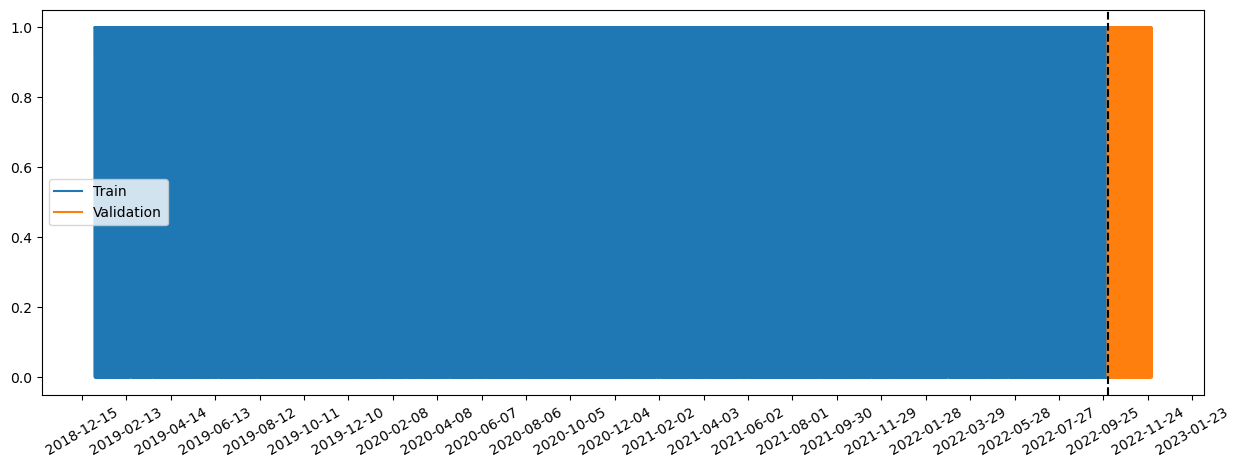

In [91]:
f, ax = plt.subplots(figsize=(15,5))
ax.plot(dates_train, y_train)
if cfg.is_validation_phase:
    ax.plot(dates_eval, y_eval)
    ax.axvline(x=pd.DatetimeIndex([cfg.split_date])[0], color='black', ls='--')
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=30)
plt.legend(['Train', 'Validation'])
plt.show()

## Model

In [92]:
new_df.columns[5:8].tolist()

['diff>0', 'close-open>0', '(close-open)/open>0']

In [93]:
# config
tf.keras.backend.clear_session()

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=50,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

if target in new_df.columns[5:8].tolist():
    loss=losses.BinaryCrossentropy(from_logits=True)
    metric=metrics.BinaryAccuracy()
else:
    loss=losses.MeanSquaredError()
    metric=metrics.MeanAbsoluteError()
    
if cfg.is_validation_phase:
    validation_data = ([x_seq_eval, x_tab_eval], y_eval)
else:
    validation_data = None

batch_size = 512

# model
LSTM_model = Sequential([
    layers.LSTM(128, return_sequences=False, input_shape=(window_size-1,1), activation='relu'),
    #layers.LSTM(64, return_sequences=False),
    layers.Dense(16, activation='relu'),
])

DENSE_model = Sequential([
    layers.Dense(0, activation='relu', input_shape=(x_tab_train.shape[1],)),
    #layers.Dense(32, activation='relu'),
    #layers.Dense(32, activation='relu'),
])

inputs = layers.concatenate([LSTM_model.output, DENSE_model.output])
l = layers.Dense(32, activation='relu')(inputs)
l = layers.Dense(1, activation='linear')(l)

MIX_model = Model(inputs=[LSTM_model.input, DENSE_model.input], outputs=l)

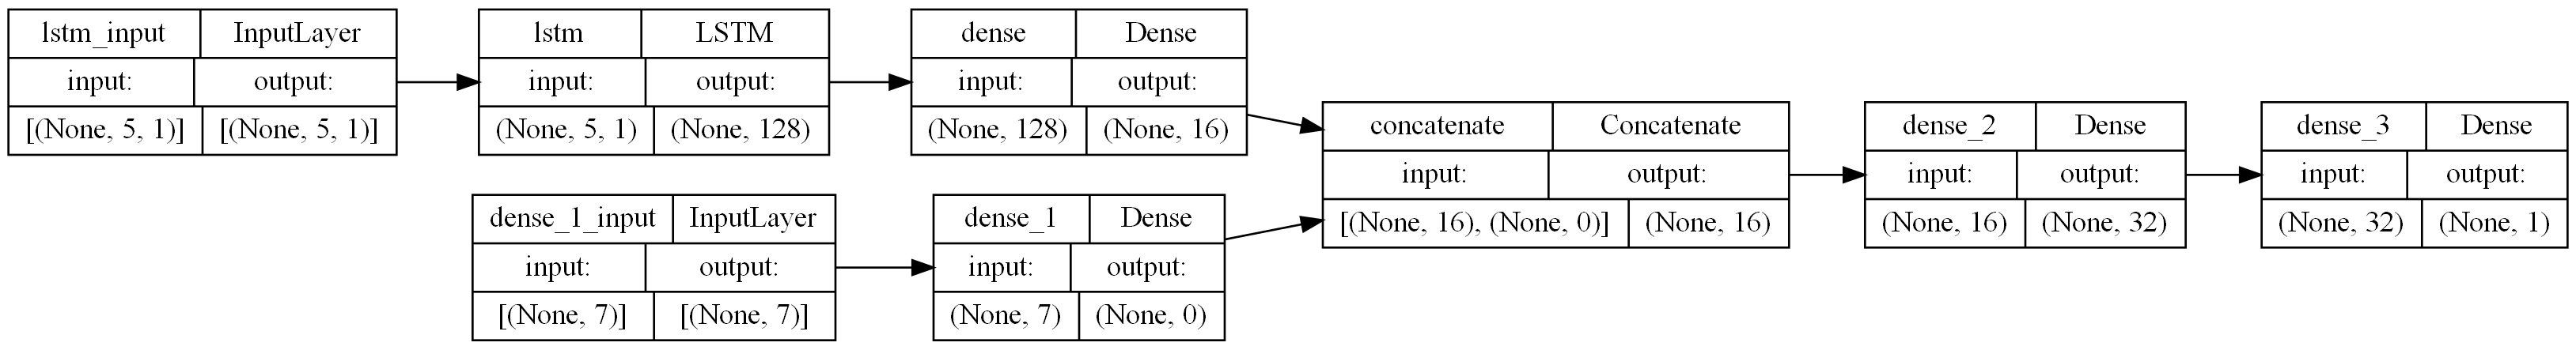

In [94]:
# plotting model
tf.keras.utils.plot_model(
    MIX_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=False,
    dpi=96*2,
    layer_range=None,
    show_layer_activations=False)

In [95]:
MIX_model.compile(loss=loss, optimizer=optimizers.Adam(0.0001), metrics=metric, )
history = MIX_model.fit([x_seq_train, x_tab_train], y_train, 
                        validation_data =validation_data, 
                        epochs=500, 
                        batch_size=batch_size,
                        callbacks=[es]
                       )
print('-'*100)
#print(min(history.history['loss']),'-------', min(history.history['val_loss']))



Epoch 1/500
65/65 [==============================] - 2s 15ms/step - loss: 0.6958 - binary_accuracy: 0.4981 - val_loss: 0.6901 - val_binary_accuracy: 0.5219
Epoch 2/500
65/65 [==============================] - 1s 9ms/step - loss: 0.6909 - binary_accuracy: 0.4958 - val_loss: 0.6892 - val_binary_accuracy: 0.5219
Epoch 3/500
65/65 [==============================] - 1s 8ms/step - loss: 0.6900 - binary_accuracy: 0.4964 - val_loss: 0.6886 - val_binary_accuracy: 0.5226
Epoch 4/500
65/65 [==============================] - 1s 9ms/step - loss: 0.6894 - binary_accuracy: 0.4953 - val_loss: 0.6890 - val_binary_accuracy: 0.5219
Epoch 5/500
65/65 [==============================] - 1s 9ms/step - loss: 0.6888 - binary_accuracy: 0.4961 - val_loss: 0.6899 - val_binary_accuracy: 0.5240
Epoch 6/500
65/65 [==============================] - 1s 9ms/step - loss: 0.6887 - binary_accuracy: 0.4975 - val_loss: 0.6887 - val_binary_accuracy: 0.5219
Epoch 7/500
65/65 [==============================] - 1s 9ms/step - lo

65/65 [==============================] - 1s 9ms/step - loss: 0.6754 - binary_accuracy: 0.5130 - val_loss: 0.6936 - val_binary_accuracy: 0.5190
Epoch 54/500
65/65 [==============================] - 1s 9ms/step - loss: 0.6750 - binary_accuracy: 0.5150 - val_loss: 0.6928 - val_binary_accuracy: 0.5197
Epoch 55/500
65/65 [==============================] - 1s 8ms/step - loss: 0.6751 - binary_accuracy: 0.5153 - val_loss: 0.6930 - val_binary_accuracy: 0.5176
Epoch 56/500
65/65 [==============================] - 1s 10ms/step - loss: 0.6745 - binary_accuracy: 0.5140 - val_loss: 0.6947 - val_binary_accuracy: 0.5197
Epoch 57/500
65/65 [==============================] - 1s 9ms/step - loss: 0.6747 - binary_accuracy: 0.5144 - val_loss: 0.6952 - val_binary_accuracy: 0.5176
Epoch 58/500
65/65 [==============================] - 1s 10ms/step - loss: 0.6740 - binary_accuracy: 0.5149 - val_loss: 0.6938 - val_binary_accuracy: 0.5197
Epoch 59/500
65/65 [==============================] - 1s 9ms/step - loss: 0

In [96]:
MIX_model.save('Models/MIX_model')

INFO:tensorflow:Assets written to: Models/MIX_model\assets


In [97]:
#tf.keras.backend.clear_session()

In [98]:
#MIX_model = tf.keras.models.load_model('Models/MIX_model')

In [99]:
if cfg.is_validation_phase:
    pred_eval = MIX_model.predict(validation_data[0])
    print(np.sqrt(mean_squared_error(y_eval, pred_eval)))
    pred_train = MIX_model.predict([x_seq_train, x_tab_train])
    print(np.sqrt(mean_squared_error(y_train, pred_train)))
else:
    pred_train = MIX_model.predict([x_seq_train, x_tab_train])
    print(np.sqrt(mean_squared_error(y_train, pred_train)))

45/45 [==============================] - 0s 2ms/step
0.6785594592586531
1027/1027 [==============================] - 2s 2ms/step
0.71277657180661


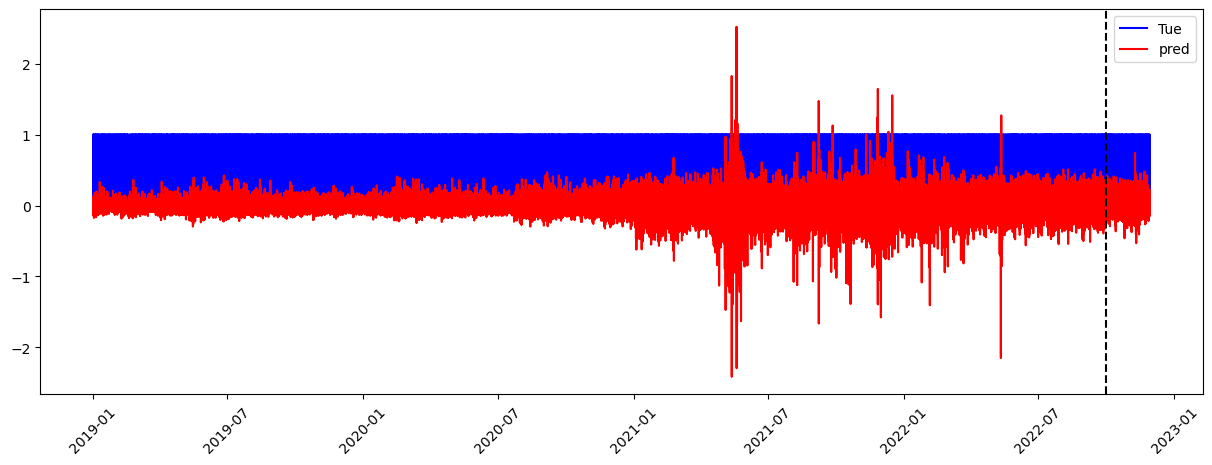

In [100]:
f, ax = plt.subplots(figsize=(15,5))
if cfg.is_validation_phase:
    ax.plot(dates_train, y_train, color='b')
    ax.plot(dates_train, pred_train, color='r')
    ax.plot(dates_eval, y_eval, color='b')
    ax.plot(dates_eval, pred_eval, color='r')
    
    ax.axvline(x=pd.DatetimeIndex([cfg.split_date])[0], color='black', ls='--')
else:
    ax.plot(m4_train_dates, p, color='r')
    ax.plot(m4_train_dates, m4_train_y, color='b')
ax.legend(['Tue', 'pred'])
plt.xticks(rotation = 45)
plt.show()

In [101]:
result = pd.DataFrame()
result['y'] = y_eval
result['pred'] = pred_eval
#result['y>0'] = y_eval>0
#result['pred>0'] = pred_eval>0
#result['acc'] = result['y>0']==result['pred>0']
result['y_diff'] = result['y'].diff()
result['pred_diff'] = result['pred'].diff()
result['y>0'] = result['y_diff']>0
result['pred>0'] = result['pred_diff']>0
result['acc'] = result['y>0']==result['pred>0']

In [102]:
result

,y,pred,y_diff,pred_diff,y>0,pred>0,acc
0,0.0,0.085898,NaN,NaN,False,False,True
1,1.0,0.068109,1.0,-0.017790,True,False,False
2,0.0,-0.109875,-1.0,-0.177984,False,False,True
3,0.0,-0.068564,0.0,0.041311,False,True,False
4,0.0,-0.012860,0.0,0.055705,False,True,False
...,...,...,...,...,...,...,...
1413,0.0,-0.147483,-1.0,-0.115482,False,False,True
1414,0.0,0.027396,0.0,0.174879,False,True,False
1415,0.0,0.098842,0.0,0.071446,False,True,False
1416,0.0,0.190420,0.0,0.091577,False,True,False


In [ ]:
result['acc'].sum()/len(result)